# Modelo de série temporal para prever as vendas mensais dos produtos
O objetivo do modelo é predizer a quantidade mensal de vendas de cada item utilizando os dados das notas fiscais, considerando as variáveis: código dos item, data de emissão da NF e a quantidade vendida. A quantidade vendida de cada item por mês é a variável resposta do modelo, já as variáveis regressoras foram construídas com base nas quantidades dos meses anteriores de cada observação para cada item. A estratégia utilizada foi criar variáveis que pudessem identificar os padrões passados de venda de cada item, para tanto, foram construídas variáveis de médias, dispersão, máximo, mínimo e tendência. A técnica de diferenciação também foi utilizada para tratar a sazonalidade. O algoritmo utilizado para a predição foi o Random Forest e a avaliação do resultado do modelo foi realizada através do RMSE(Root Mean Square Error).

In [1]:
import os
os.getcwd()

'C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Importação dos dados

In [3]:
nf=pd.read_csv('nf_item_12_13_14.csv',sep=';')

In [4]:
nf.head()

,Nota_Fiscal,Item,Nat_Oper,Emissão,Quant
0,28159,105A/9,5101RE,2012-01-02,50.0
1,28159,770F/8,5101RE,2012-01-02,80.0
2,28159,770F/9,5101RE,2012-01-02,60.0
3,28160,0920/7,5101TO,2012-01-02,100.0
4,28160,0920/8,5101TO,2012-01-02,100.0


In [5]:
len(nf)

286541

#### Ajuste da variável Emissão

In [6]:
nf['Emissão']=pd.to_datetime(nf['Emissão'],infer_datetime_format=True)

In [7]:
nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286541 entries, 0 to 286540
Data columns (total 5 columns):
Nota_Fiscal    286541 non-null int64
Item           286541 non-null object
Nat_Oper       286541 non-null object
Emissão        286541 non-null datetime64[ns]
Quant          286541 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 10.9+ MB


#### Sumarização dos itens por emissão. Soma das quantidades de cada item por data de emissão.
(item-NF para item-dia)

In [8]:
nf=nf.groupby(['Item','Emissão'],as_index=False).agg({'Quant':'sum'})

In [9]:
nf.head()

,Item,Emissão,Quant
0,01050/10,2014-11-03,20.0
1,01050/7,2014-05-05,10.0
2,01050/7,2014-11-03,20.0
3,01050/8,2014-04-15,10.0
4,01050/8,2014-05-05,10.0


In [10]:
len(nf)

77225

#### Supressão dos itens com vendas inferiores a um mil unidades durante o período de 36 meses.

In [11]:
sum_item=nf.groupby(['Item'],as_index=False).agg({'Quant':'sum'})

In [12]:
itens_sel=sum_item['Item'][sum_item['Quant']>1000]
itens_sel.head()

4      0126/10
5       0126/9
6    0340/3-GD
7    0340/4-GD
8    0340/4-PQ
Name: Item, dtype: object

In [13]:
nf_1=nf[nf['Item'].isin(itens_sel)]

In [14]:
nf_1.head()

,Item,Emissão,Quant
11,0126/10,2013-02-07,10.0
12,0126/10,2013-02-15,10.0
13,0126/10,2013-03-26,10.0
14,0126/10,2013-05-17,50.0
15,0126/10,2013-08-05,10.0


In [15]:
len(nf_1)

75314

#### Extração do mês da data

In [16]:
nf_1['Mês']=nf_1['Emissão'].dt.month

#### Extração do ano da data

In [17]:
nf_1['Ano']=nf_1['Emissão'].dt.year

In [18]:
nf_1.tail()

,Item,Emissão,Quant,Mês,Ano
77129,O351/10,2014-12-01,1.0,12,2014
77130,O351/10,2014-12-10,1.0,12,2014
77131,O351/10,2014-12-17,14.0,12,2014
77132,O351/10,2014-12-18,2.0,12,2014
77133,O351/10,2014-12-19,1.0,12,2014


In [19]:
len(nf_1)

75314

#### Transformação dos meses de 1 a 12 do período de dois anos para 1 a 36 meses.

In [20]:
l=[]
for index,row in nf_1.iterrows():
    if row['Ano']==2013:
        m=row['Mês']+12
        l.append(m)
    elif row['Ano']==2014:
        n=row['Mês']+24
        l.append(n)    
    else:
        l.append(row['Mês'])
nf_1['Mês_2']=l

In [21]:
nf_1.tail()

,Item,Emissão,Quant,Mês,Ano,Mês_2
77129,O351/10,2014-12-01,1.0,12,2014,36
77130,O351/10,2014-12-10,1.0,12,2014,36
77131,O351/10,2014-12-17,14.0,12,2014,36
77132,O351/10,2014-12-18,2.0,12,2014,36
77133,O351/10,2014-12-19,1.0,12,2014,36


#### Sumarização dos itens por Mês_2. Soma das quantidades de cada item por mês de 1 a 36.

In [22]:
nf_2=nf_1.groupby(['Item','Mês_2','Mês'],as_index=False).agg({'Quant':'sum'})

In [23]:
nf_2[nf_2['Item']=='0126/10']

,Item,Mês_2,Mês,Quant
0,0126/10,14,2,20.0
1,0126/10,15,3,10.0
2,0126/10,17,5,50.0
3,0126/10,20,8,10.0
4,0126/10,22,10,120.0
5,0126/10,23,11,150.0
6,0126/10,25,1,170.0
7,0126/10,28,4,648.0
8,0126/10,31,7,50.0
9,0126/10,33,9,10.0


In [24]:
nf_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7361 entries, 0 to 7360
Data columns (total 4 columns):
Item     7361 non-null object
Mês_2    7361 non-null int64
Mês      7361 non-null int64
Quant    7361 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 287.5+ KB


#### Verificação de sazonalidade

#### Construção de gráfico das vendas dos períodos de 1 a 29(períodos que serão utilizados no treinamento do modelo) com os valores agregados de venda.

In [25]:
nf_p=nf_2.sort_values(by=['Mês_2','Item'])
nf_p=nf_p.reset_index(drop=True)

In [26]:
y=nf_p[(nf_p['Mês_2']<=12)]
print(len(y))

2379


In [27]:
yy=nf_p[(nf_p['Mês_2']>12)&(nf_p['Mês_2']<=24)]
print(len(yy))

2476


In [28]:
yyy=nf_p[nf_p['Mês_2']>24]
print(len(yyy))

2506


In [29]:
lim=round(len(y)+((len(yy)+len(yyy))*0.7)) #limite de 70% da base de treinamento
print(lim)

5866


In [30]:
nf_p.iloc[lim]

Item     750PT/9
Mês_2         29
Mês            5
Quant      94612
Name: 5866, dtype: object

Foi indentificada sazonalidade no mês de dezembro através do gráfico abaixo. Os meses de dezembro(12 e 24 no gráfico) apresentaram um expressivo declínio, quando considerados os dados agregados de todos os itens. Embora, possivelmente, essa sazonalidade não seja refletida em todos os itens, ela exprime a maior parte das vendas nesses períodos 12 e 24 e, provavelmente, poderá repetir-se no período 36.

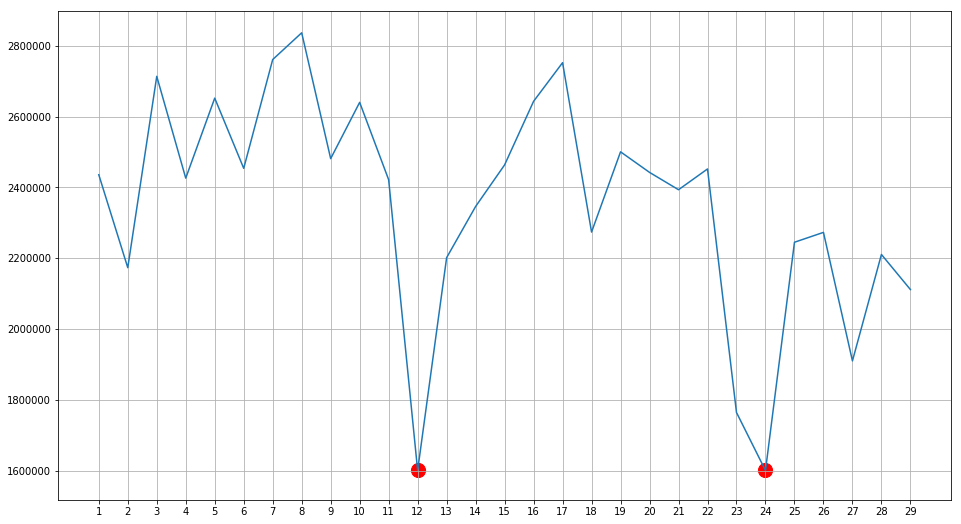

In [31]:
plt.rcParams['figure.figsize']=(16,9)
nf_p_agg=nf_p[nf_p['Mês_2']<=29].groupby(['Mês_2']).agg({'Quant':'sum'})
plt.plot(list(range(1,30)),nf_p_agg)
plt.xticks(list(range(1,30)))
a=nf_p_agg.iloc[11]
b=nf_p_agg.iloc[23]
plt.scatter(12,a,s=200,c='red')
plt.scatter(24,b,s=200,c='red')
plt.grid(True)

#### Tratamento da sazonalidade


Foi utilizada a técnica de diferenciação para tratamento da sazonalidade. Como foi identificada uma sazonalidade de 12 meses, foi realizada a subtração do valor do período -12 para cada observação para que fosse reduzido o efeito da sazonalidade, evitando-se que a predição sofresse interferência desse efeito. Ao final da predição, o valor subtraído foi adicionado ao valor predito.

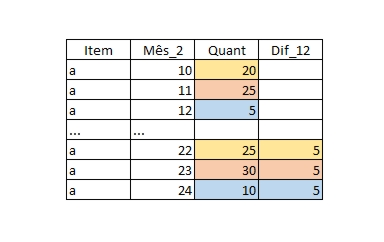

In [32]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\dif_12.jpg")

In [33]:
l=list(nf_2['Item'].unique())
l_12=[]
for i in l:
    df_item=nf_2[nf_2['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        q=row['Quant']
        m=row['Mês_2']-12
        d=df_item[df_item['Mês_2']==m]['Quant']
        dl=d.tolist()
        if not dl:
            dl.insert(0,0)
        else:
            dl
        q_12=q-dl[0]
        l_12.append(q_12)
nf_2['Dif_12']=l_12

In [34]:
nf_2[nf_2['Item']=='102A/9']

,Item,Mês_2,Mês,Quant,Dif_12
4344,102A/9,1,1,60912.0,60912.0
4345,102A/9,2,2,59590.0,59590.0
4346,102A/9,3,3,67213.0,67213.0
4347,102A/9,4,4,50020.0,50020.0
4348,102A/9,5,5,57588.0,57588.0
4349,102A/9,6,6,63480.0,63480.0
4350,102A/9,7,7,57146.0,57146.0
4351,102A/9,8,8,68503.0,68503.0
4352,102A/9,9,9,46530.0,46530.0
4353,102A/9,10,10,42603.0,42603.0


Ajuste do período de treinamento e teste. Como foi realizado o tratamento da sazonalidade, os períodos de 1 a 12 não foram utilizados para treinamento do modelo, pois esses valores não foram ajustados com a diferença do período -12. Esses meses foram retirados do banco de dados. Os valores dos períodos de 1 a 12 foram utiliados após a predição para recompor os valores originais dos dados.

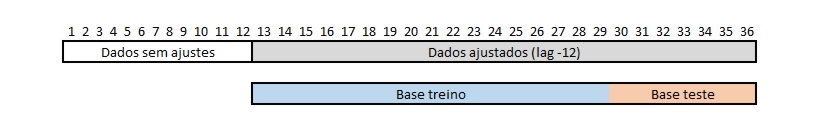

In [35]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\dif_12_2.jpg")

In [36]:
nf_3=nf_2[nf_2['Mês_2']>12]

In [37]:
nf_3=nf_3.reset_index(drop=True)

In [38]:
nf_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4982 entries, 0 to 4981
Data columns (total 5 columns):
Item      4982 non-null object
Mês_2     4982 non-null int64
Mês       4982 non-null int64
Quant     4982 non-null float64
Dif_12    4982 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 194.7+ KB


#### Cálculo da média dos meses anteriores. 
O objetivo foi calcular a média das observações de cada item do período entre o primeiro mês do dataset e o mês anterior ao de destino do cálculo.

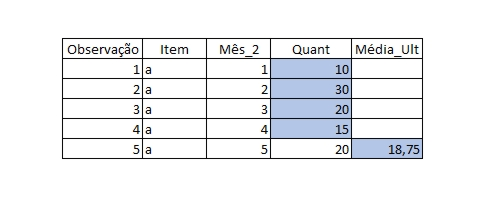

In [39]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\media.jpg")

In [40]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Dif_12']:
                m=df_item_2['Dif_12'].mean()
        l_m.append(m)
nf_3['Média_Ult']=l_m

In [41]:
nf_3[nf_3['Item']=='0126/10']

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult
0,0126/10,14,2,20.0,20.0,0.000000
1,0126/10,15,3,10.0,10.0,20.000000
2,0126/10,17,5,50.0,50.0,15.000000
3,0126/10,20,8,10.0,10.0,26.666667
4,0126/10,22,10,120.0,120.0,22.500000
5,0126/10,23,11,150.0,150.0,42.000000
6,0126/10,25,1,170.0,170.0,60.000000
7,0126/10,28,4,648.0,648.0,75.714286
8,0126/10,31,7,50.0,50.0,147.250000
9,0126/10,33,9,10.0,10.0,136.444444


#### Cálculo da mediana dos meses anteriores

In [42]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Dif_12']:
                m=df_item_2['Dif_12'].median()
        l_m.append(m)
nf_3['Mediana_Ult']=l_m

In [43]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult
0,0126/10,14,2,20.0,20.0,0.000000,0.0
1,0126/10,15,3,10.0,10.0,20.000000,20.0
2,0126/10,17,5,50.0,50.0,15.000000,15.0
3,0126/10,20,8,10.0,10.0,26.666667,20.0
4,0126/10,22,10,120.0,120.0,22.500000,15.0


#### Cálculo do valor mínimo dos meses anteriores

In [44]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Dif_12']:
                m=df_item_2['Dif_12'].min()
        l_m.append(m)
nf_3['Min_Ult']=l_m

In [45]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0


#### Cálculo do valor máximo dos meses anteriores

In [46]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Dif_12']:
                m=df_item_2['Dif_12'].max()
        l_m.append(m)
nf_3['Max_Ult']=l_m

In [47]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0


#### Cálculo do desvio padrão dos meses anteriores

In [48]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0 or index==1:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Dif_12']:
                m=df_item_2['Dif_12'].std()
        l_m.append(m)
nf_3['Desv_Ult']=l_m

In [49]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694


#### Criação da variável com o valor da quantidade do mês anterior(-1)

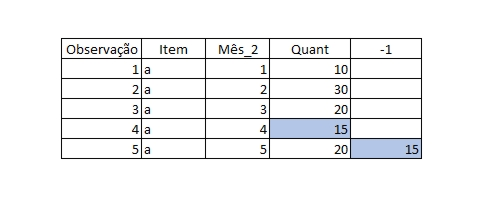

In [50]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\anterior_1.jpg")

In [51]:
l=list(nf_3['Item'].unique())
l_l=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_item=list(df_item.Dif_12)
    q_df_shift=list(df_item.Dif_12.shift(1))
    q_df_shift[0]=0
    l_l+=q_df_shift
nf_3['-1']=l_l

In [52]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0


#### Criação da variável com o valor da quantidade do segundo mês anterior

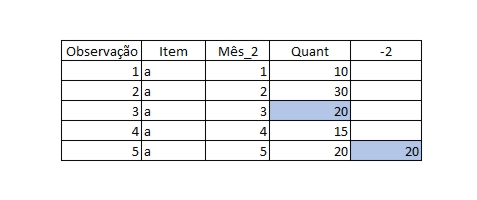

In [53]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\anterior_2.jpg")

In [54]:
l=list(nf_3['Item'].unique())
l_l=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_item=list(df_item.Dif_12)
    if len(q_df_item)>=3:
        q_df_shift=list(df_item.Dif_12.shift(2))
        q_df_shift[0]=0
        q_df_shift[1]=0
    elif len(q_df_item)==2:
        q_df_shift=[0,0]
    else:
        q_df_shift=[0]
    l_l+=q_df_shift
nf_3['-2']=l_l

In [55]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0


#### Criação da variável com o valor da quantidade do terceiro mês anterior

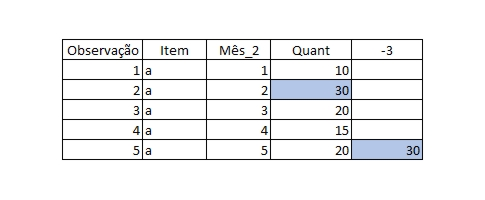

In [56]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\anterior_3.jpg")

In [57]:
l=list(nf_3['Item'].unique())
l_l=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_item=list(df_item.Dif_12)
    if len(q_df_item)>=4:
        q_df_shift=list(df_item.Dif_12.shift(3))
        q_df_shift[0]=0
        q_df_shift[1]=0
        q_df_shift[2]=0
    elif len(q_df_item)==3:
        q_df_shift=[0,0,0]
    elif len(q_df_item)==2:
        q_df_shift=[0,0]
    else:
        q_df_shift=[0]
    l_l+=q_df_shift
nf_3['-3']=l_l

In [58]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0


#### Criação da variável com o valor da diferença entre as duas quantidades dos meses anteriores

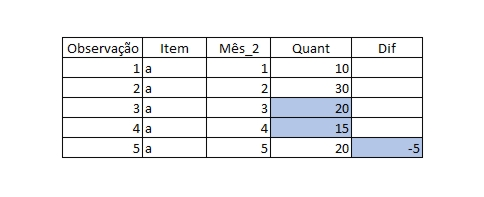

In [59]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\dif.jpg")

In [60]:
l=list(nf_3['Item'].unique())
l_d=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_shift_1=list(df_item.Dif_12.shift(1))
    q_df_shift_2=list(df_item.Dif_12.shift(2))
    zip_object=zip(q_df_shift_1, q_df_shift_2)
    diff=[]
    for q_df_shift_1_i, q_df_shift_2_i in zip_object:
        diff.append(q_df_shift_1_i-q_df_shift_2_i)
    l_d+=diff
nf_3['Dif_1']=l_d
nf_3['Dif_1']=nf_3['Dif_1'].fillna(0)

In [61]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0,0.0
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0,-10.0
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0,40.0
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0,-40.0


#### Criação da variável com o valor da média móvel das últimos seis meses

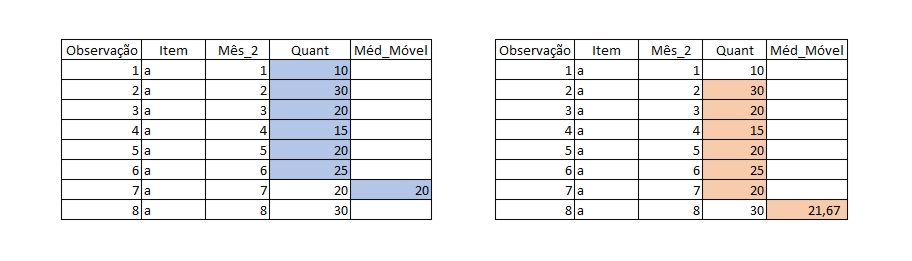

In [62]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\movel.jpg")

In [63]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Dif_12']:
                m=df_item_2['Dif_12'].tail(3).mean()
        l_m.append(m)
nf_3['Méd_Móvel_3']=l_m

In [64]:
nf_3.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1,Méd_Móvel_3
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0,0.0,20.000000
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0,-10.0,15.000000
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0,40.0,26.666667
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0,-40.0,23.333333


#### Criação das variáveis coeficientes linear e angular da reta ajustada a série de dados. 
O objetivo de calcular esses coeficientes foi tentar captar a tendência da série.

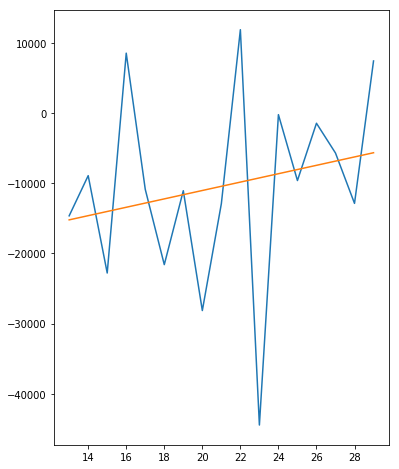

coeficiente angular: 598.0343137254906
coeficiente linear: -22981.073529411766
equação da reta: -22981.073529411766 + 598.0343137254906*X


In [65]:
item_sel=nf_3[(nf_3['Item']=='102A/9') & (nf_3['Mês_2']<=29)]
y=item_sel['Dif_12'].values
x=list(item_sel['Mês_2'])
X=np.linspace(x[0],x[-1])
Y=(np.poly1d(np.polyfit(x, y, 1))[1])*X+np.poly1d(np.polyfit(x, y, 1))[0]

plt.figure(figsize=(6,8))
plt.plot(x,y)
plt.plot(X,Y)
plt.show()

print('coeficiente angular:'+' '+str(np.poly1d(np.polyfit(x, y, 1))[1]))
print('coeficiente linear:'+' '+str(np.poly1d(np.polyfit(x, y, 1))[0]))
print('equação da reta:'+' '+str(np.poly1d(np.polyfit(x, y, 1))[0])+' '+'+'+' '+str(np.poly1d(np.polyfit(x, y, 1))[1])+'*X')

In [66]:
l=list(nf_3['Item'].unique())
coef_dic={'Item':[],'Coef_Ang':[],'Coef_Lin':[]}
for i in l:
    df=nf_3[nf_3['Item']==i]
    df=df.reset_index()
    for index,row in df.iterrows():
        df_2=df[df['Mês_2']<row['Mês_2']]
    
        month=[]
        for k in range(len(df_2)-1):
            j=(df_2['Mês_2'][k+1]-df_2['Mês_2'][0])
            month.append(j)
        x=month
        x.insert(0,0)
        y=df_2['Dif_12']
        y1=list(df_2['Dif_12'])
        if len(df)>1:
            try:
                coef=np.polyfit(x, y, 1)
            except:
                coef=[]
                try:
                    ang=(y1[-1] - y1[0])/(x[-1] - x[0])
                except:
                    ang=0
                if ang != 0:
                    lin=(sum(y1)/len(y1))-(ang*(sum(x)/len(x)))
                else:
                    lin=0
                coef.append(ang)
                coef.append(lin)
        else:
            coef=[0,0]
        coef_dic['Item'].append(i)
        coef_dic['Coef_Ang'].append(coef[0])
        coef_dic['Coef_Lin'].append(coef[1])
    coef_df=pd.DataFrame(coef_dic)

In [67]:
coef_df=pd.DataFrame(coef_dic)

In [68]:
coef_df.head()

,Item,Coef_Ang,Coef_Lin
0,0126/10,0.000000,0.000000
1,0126/10,0.000000,0.000000
2,0126/10,-10.000000,20.000000
3,0126/10,11.428571,11.428571
4,0126/10,-0.238095,23.095238


#### Junção dos coeficientes linear e angular as outras variáveis

In [69]:
nf_4=pd.concat([nf_3,coef_df],axis=1)

In [70]:
nf_4.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1,Méd_Móvel_3,Item,Coef_Ang,Coef_Lin
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0126/10,0.000000,0.000000
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0,0.0,20.000000,0126/10,0.000000,0.000000
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0,-10.0,15.000000,0126/10,-10.000000,20.000000
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0,40.0,26.666667,0126/10,11.428571,11.428571
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0,-40.0,23.333333,0126/10,-0.238095,23.095238


In [71]:
nf_4=nf_4.loc[:,~nf_4.columns.duplicated()]

In [72]:
nf_4.head()

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1,Méd_Móvel_3,Coef_Ang,Coef_Lin
0,0126/10,14,2,20.0,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0126/10,15,3,10.0,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0,0.0,20.000000,0.000000,0.000000
2,0126/10,17,5,50.0,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0,-10.0,15.000000,-10.000000,20.000000
3,0126/10,20,8,10.0,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0,40.0,26.666667,11.428571,11.428571
4,0126/10,22,10,120.0,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0,-40.0,23.333333,-0.238095,23.095238


#### Verificação de missing values

In [73]:
pd.isnull(nf_4).sum()

Item           0
Mês_2          0
Mês            0
Quant          0
Dif_12         0
Média_Ult      0
Mediana_Ult    0
Min_Ult        0
Max_Ult        0
Desv_Ult       0
-1             0
-2             0
-3             0
Dif_1          0
Méd_Móvel_3    0
Coef_Ang       0
Coef_Lin       0
dtype: int64

In [74]:
len(coef_df)

4982

#### Ordenação dos dados pelo mês

In [75]:
nf_5=nf_4.sort_values(by=['Mês_2','Item'])

#### Criação de um novo índice com base na variável Mês_2

In [76]:
nf_5=nf_5.reset_index(drop=True)

In [77]:
nf_5['Mês']=nf_5['Mês'].astype('category')

In [78]:
nf_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4982 entries, 0 to 4981
Data columns (total 17 columns):
Item           4982 non-null object
Mês_2          4982 non-null int64
Mês            4982 non-null category
Quant          4982 non-null float64
Dif_12         4982 non-null float64
Média_Ult      4982 non-null float64
Mediana_Ult    4982 non-null float64
Min_Ult        4982 non-null float64
Max_Ult        4982 non-null float64
Desv_Ult       4982 non-null float64
-1             4982 non-null float64
-2             4982 non-null float64
-3             4982 non-null float64
Dif_1          4982 non-null float64
Méd_Móvel_3    4982 non-null float64
Coef_Ang       4982 non-null float64
Coef_Lin       4982 non-null float64
dtypes: category(1), float64(14), int64(1), object(1)
memory usage: 628.1+ KB


In [79]:
nf_5.head(10)

,Item,Mês_2,Mês,Quant,Dif_12,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1,Méd_Móvel_3,Coef_Ang,Coef_Lin
0,0340/3-GD,13,1,25332.0,-4696.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0340/4-GD,13,1,143248.0,19193.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0341/3-GD,13,1,3000.0,2250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0348/4-GD,13,1,3268.0,-15982.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0348/4-MD,13,1,230.0,-990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0349/4-GD,13,1,1800.0,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0380/FN-GD,13,1,113.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0380/FN-MD,13,1,21.0,-21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0380/FN-PQ,13,1,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0385/MD,13,1,200.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Seleção das variáveis regressoras

In [80]:
x = nf_5.drop(['Item','Mês_2','Quant','Dif_12','Coef_Lin'], axis = 1)

In [81]:
x.head()

,Mês,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1,Méd_Móvel_3,Coef_Ang
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Seleção da variável resposta

In [82]:
y=nf_5.Dif_12

In [83]:
y.head()

0    -4696.0
1    19193.0
2     2250.0
3   -15982.0
4     -990.0
Name: Dif_12, dtype: float64

#### Divisão do banco em treino e teste. 
A estratégia foi dividir o banco original na proporção de 70% para treino e 30% para o teste final, contudo o banco de treino foi dividido novamente em três bancos de treino e validação, utilizando a técnica kfold, a fim de treinar o modelo e selecionar os melhores parâmetros. No final do treino, o modelo foi avaliado utilizando o banco teste. Por se tratar de uma série temporal, a divisão entre treino e teste não foi realizada de forma aleatória, foi respeitdada a temporalidade dos dados.

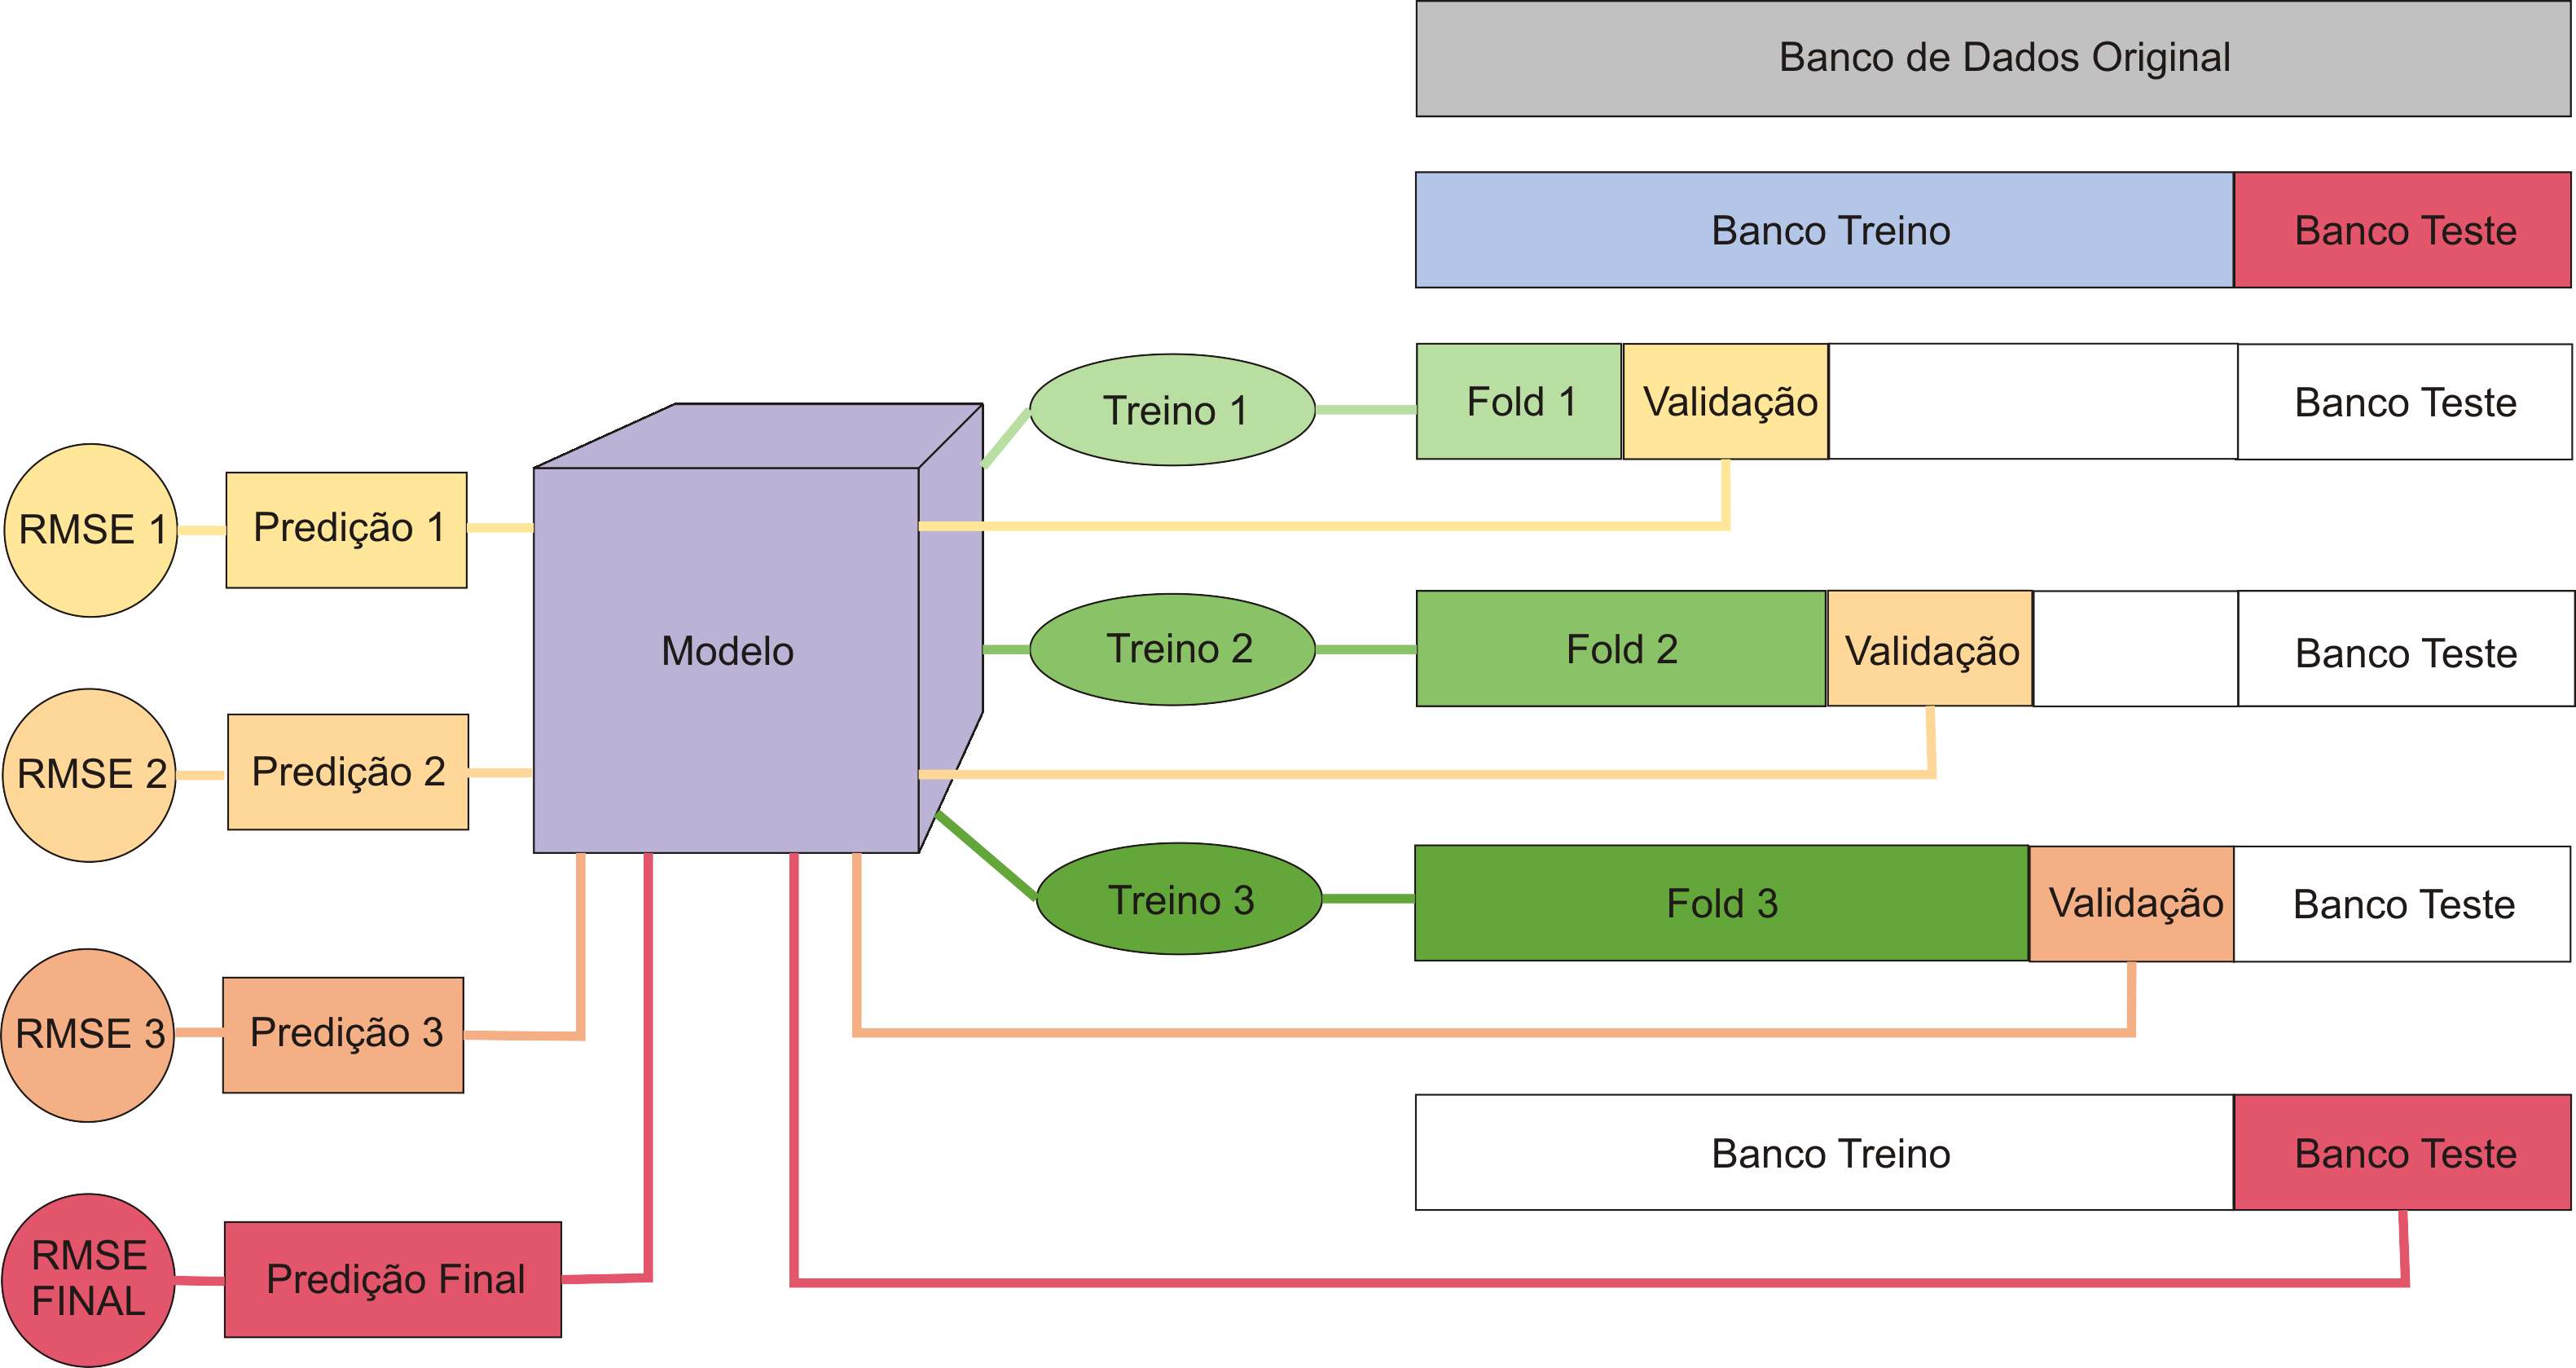

In [84]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\kfold.png")

In [85]:
lim=round(len(x)*0.7)

In [86]:
print(lim)

3487


In [87]:
train_x=x.loc[0:lim]

In [88]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3488 entries, 0 to 3487
Data columns (total 12 columns):
Mês            3488 non-null category
Média_Ult      3488 non-null float64
Mediana_Ult    3488 non-null float64
Min_Ult        3488 non-null float64
Max_Ult        3488 non-null float64
Desv_Ult       3488 non-null float64
-1             3488 non-null float64
-2             3488 non-null float64
-3             3488 non-null float64
Dif_1          3488 non-null float64
Méd_Móvel_3    3488 non-null float64
Coef_Ang       3488 non-null float64
dtypes: category(1), float64(11)
memory usage: 303.6 KB


In [89]:
train_y=y.loc[0:lim]

In [90]:
test_x=x.loc[lim+1:]

In [91]:
test_y=y.loc[lim+1:]

In [92]:
train_x.tail()

,Mês,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1,Méd_Móvel_3,Coef_Ang
3483,5,-1727.7500,-1286.0,-6332.0,4080.0,2872.932149,-4490.0,760.0,-3050.0,-5250.0,-2260.000000,-153.429412
3484,5,6823.6250,5261.0,-22060.0,25904.0,13055.010807,3918.0,-22060.0,-1280.0,25978.0,-6474.000000,-1530.102941
3485,5,-538.4375,796.5,-12144.0,9929.0,5395.941919,-3629.0,2943.0,1494.0,-6572.0,269.333333,72.104412
3486,5,2009.8750,1492.5,-12749.0,19171.0,9998.564763,9036.0,-4464.0,9114.0,13500.0,4562.000000,702.500000
3487,5,2550.4375,6482.5,-32488.0,30930.0,17371.796718,8753.0,-4062.0,30930.0,12815.0,11873.666667,1933.013235


In [93]:
test_x.head()

,Mês,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif_1,Méd_Móvel_3,Coef_Ang
3488,5,-193.812500,-135.0,-1150.0,820.0,557.719549,-334.0,61.0,-4.0,-395.0,-92.333333,-1.192647
3489,5,-930.625000,-241.0,-6310.0,3280.0,2736.373217,184.0,-328.0,-1848.0,512.0,-664.000000,69.994118
3490,5,-1596.937500,-1546.5,-10362.0,2973.0,3222.642652,-1212.0,-4487.0,-2110.0,3275.0,-2603.000000,-104.316176
3491,5,-3202.625000,-2517.0,-11824.0,1440.0,3381.650916,-5540.0,-1909.0,-3576.0,-3631.0,-3675.000000,24.517647
3492,5,1107.666667,1145.0,13.0,2165.0,1076.485640,2165.0,1145.0,13.0,1020.0,1107.666667,695.714286


In [94]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 3488 to 4981
Data columns (total 12 columns):
Mês            1494 non-null category
Média_Ult      1494 non-null float64
Mediana_Ult    1494 non-null float64
Min_Ult        1494 non-null float64
Max_Ult        1494 non-null float64
Desv_Ult       1494 non-null float64
-1             1494 non-null float64
-2             1494 non-null float64
-3             1494 non-null float64
Dif_1          1494 non-null float64
Méd_Móvel_3    1494 non-null float64
Coef_Ang       1494 non-null float64
dtypes: category(1), float64(11)
memory usage: 130.3 KB


### Modelo Kfold para time series

In [95]:
param_grid = {'n_estimators':[1000,1500,2000,2500],'max_features':['auto','sqrt','log2'],'max_depth':[10,20,30,40,50],
              'min_samples_split':[2,5,10,15,20],'min_samples_leaf':[1,2,5,10,15],'bootstrap':[True,False]}   

In [96]:
rf=RandomForestRegressor()

In [97]:
gs = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_jobs=-1, scoring="neg_mean_squared_error", 
                         verbose=10, n_iter=3)

In [98]:
X_train_kf=train_x.values
y_train_kf=train_y

In [99]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(3)
score_list=[]
for train_index, test_index in tscv.split(X_train_kf):
    X_train, X_test = X_train_kf[train_index], X_train_kf[test_index]
    y_train, y_test = y_train_kf[train_index], y_train_kf[test_index]
    gs.fit(X_train,y_train)
    y_pred = gs.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    score_list.append(score)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    9.3s remaining:   32.8s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   11.0s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   14.7s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   15.9s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   17.6s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   20.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   21.8s finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   19.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   22.2s remaining:   44.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   36.6s remaining:   45.8s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   37.8s remaining:   30.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   40.2s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   46.6s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.0min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   17.2s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   20.7s remaining:   41.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   20.7s remaining:   25.9s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   22.5s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   24.6s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   27.2s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   28.7s finished


In [100]:
np.mean(score_list)

10587.540180628901

In [101]:
est_imp=list(x.columns.values)
est_imp_df=pd.DataFrame(est_imp)
est_imp_df.columns=['Feature']
est_imp_df['Importance']=gs.best_estimator_.feature_importances_
est_imp_df

,Feature,Importance
0,Mês,0.027611
1,Média_Ult,0.180372
2,Mediana_Ult,0.125627
3,Min_Ult,0.123422
4,Max_Ult,0.026461
5,Desv_Ult,0.073171
6,-1,0.055102
7,-2,0.135008
8,-3,0.032903
9,Dif_1,0.067464


#### Predição Final

In [102]:
pred_final=gs.predict(test_x)

#### Avaliação Final - RMSE

In [103]:
mse=sum((pred_final-test_y)**2)/len(pred_final)

In [104]:
rmse=np.sqrt(mse)
print(rmse)

11028.728517956248


### Avaliação gráfica da predição

#### Criação do data frame das predições

In [105]:
pred_final_df=pd.DataFrame(pred_final)

In [106]:
pred_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 1 columns):
0    1494 non-null float64
dtypes: float64(1)
memory usage: 11.8 KB


#### Ajuste do índice

In [107]:
iti=test_x.index[0]
itf=test_x.index[-1]

In [108]:
s_12=len(nf_2[(nf_2['Mês_2']<=12)])

In [109]:
iti_aj=s_12+iti
itf_aj=s_12+itf
print(iti_aj)
print(itf_aj)

5867
7360


In [110]:
index=list(range(iti_aj,itf_aj+1))
index_df=pd.DataFrame(index)

In [111]:
print(len(index_df))
print(len(pred_final_df))

1494
1494


In [112]:
pred_final_df=pd.concat([index_df,pred_final_df],axis=1)

In [113]:
pred_final_df.head()

,0,0
0,5867,-9.887042
1,5868,-1229.983667
2,5869,-145.641419
3,5870,-47.278505
4,5871,399.810173


In [114]:
pred_final_df.columns=['index','pred']

In [115]:
pred_final_df=pred_final_df.set_index('index')

In [116]:
pred_final_df.head()

,pred
index,
5867,-9.887042
5868,-1229.983667
5869,-145.641419
5870,-47.278505
5871,399.810173


#### Criação do data frame das vendas com os valores recompostos (adição do lag-12)

In [117]:
nf_pred_final=nf_2.copy(deep=True)

In [118]:
nf_pred_final=nf_pred_final.drop(nf_pred_final.columns[5:17], axis = 1)

In [119]:
nf_pred_final.head()

,Item,Mês_2,Mês,Quant,Dif_12
0,0126/10,14,2,20.0,20.0
1,0126/10,15,3,10.0,10.0
2,0126/10,17,5,50.0,50.0
3,0126/10,20,8,10.0,10.0
4,0126/10,22,10,120.0,120.0


In [120]:
nf_pred_final=nf_pred_final.sort_values(by=['Mês_2','Item'])

In [121]:
nf_pred_final.head()

,Item,Mês_2,Mês,Quant,Dif_12
35,0340/3-GD,1,1,30028.0,30028.0
69,0340/4-GD,1,1,124055.0,124055.0
107,0341/3-GD,1,1,750.0,750.0
118,0348/4-GD,1,1,19250.0,19250.0
147,0348/4-MD,1,1,1220.0,1220.0


In [122]:
nf_pred_final=nf_pred_final.reset_index(drop=True)

#### Junção das predições com as vendas

In [123]:
nf_pred_final=pd.concat([nf_pred_final,pred_final_df],axis=1)

In [124]:
nf_pred_final=nf_pred_final.sort_values(by=['Item'])

#### Adiçao dos valores ajustados aos valores originais das vendas

In [125]:
l_r=list(nf_pred_final['Item'].unique())
l_12_r=[]
for i in l_r:
    df_item=nf_pred_final[nf_pred_final['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        q=row['Dif_12']
        m=row['Mês_2']-12
        d=df_item[df_item['Mês_2']==m]['Quant']
        dl=d.tolist()
        if not dl:
            dl.insert(0,0)
        else:
            dl
        q_12=q+dl[0]
        l_12_r.append(q_12)
nf_pred_final['Quant_2']=l_12_r

In [126]:
l_p=list(nf_pred_final['Item'].unique())
l_12_p=[]
for i in l_p:
    df_item=nf_pred_final[nf_pred_final['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        q=row['pred']
        m=row['Mês_2']-12
        d=df_item[df_item['Mês_2']==m]['Quant']
        dl=d.tolist()
        if not dl:
            dl.insert(0,0)
        else:
            dl
        q_12=q+dl[0]
        l_12_p.append(q_12)
nf_pred_final['pred_2']=l_12_p

In [127]:
nf_pred_final=nf_pred_final.sort_values(by=['Mês_2','Item'])

#### Gráficos de comparação entre real e a predição para alguns itens

In [128]:
def plot(i):
    plt.plot(nf_pred_final[nf_pred_final['Item']==i]['Mês_2'],
             nf_pred_final[nf_pred_final['Item']==i]['Quant_2'])
    plt.plot(nf_pred_final[nf_pred_final['Item']==i]['Mês_2'],
             nf_pred_final[nf_pred_final['Item']==i]['pred_2'])
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,
                30,31,32,33,34,35,36])
    print('Item: '+i)
    plt.grid(True)

Item: 101A/9


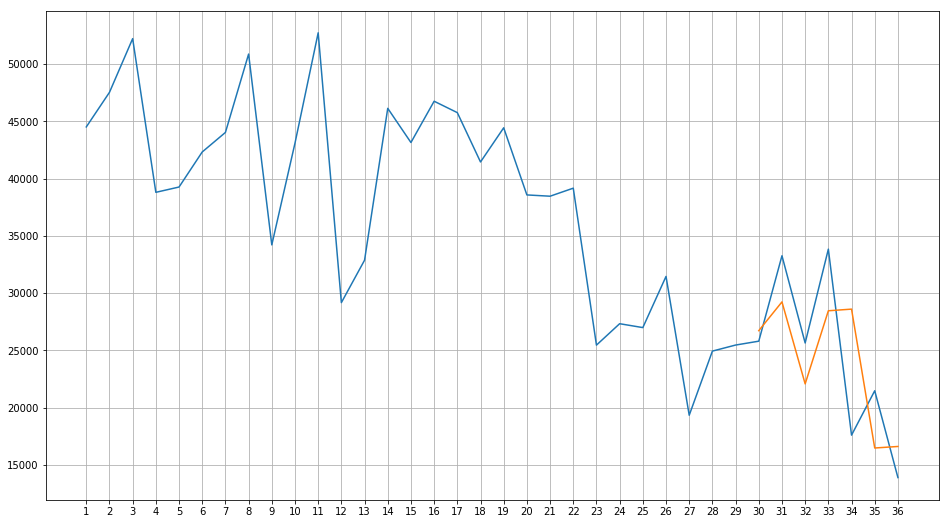

In [129]:
plot('101A/9')

Item: 102A/9


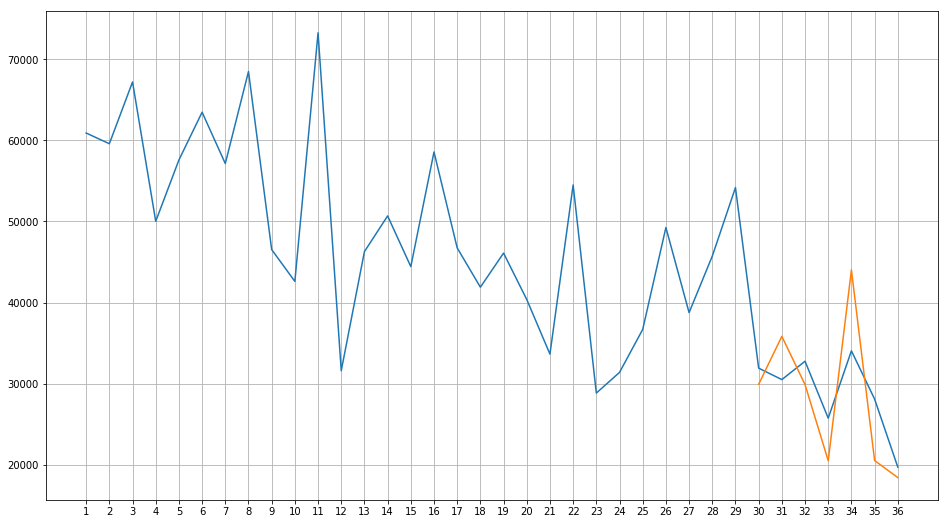

In [130]:
plot('102A/9')

Item: 0620/9


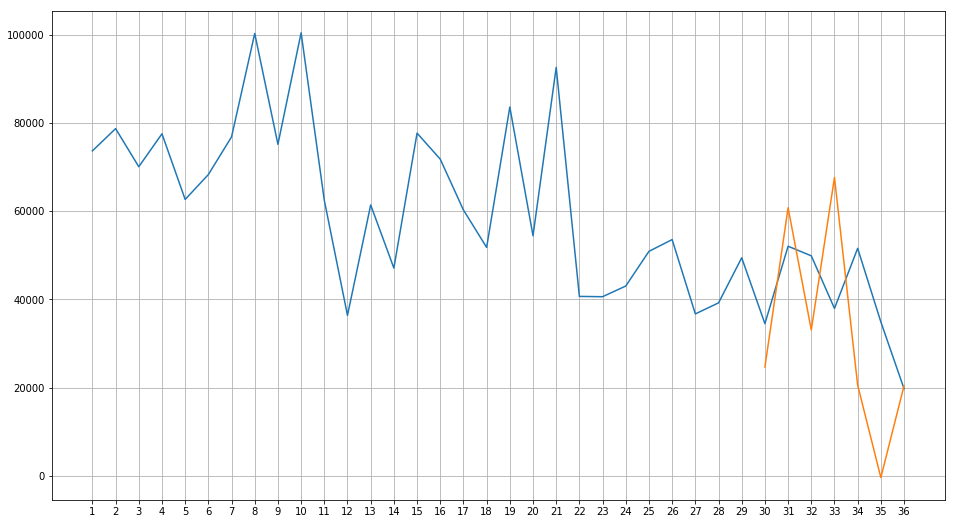

In [131]:
plot('0620/9')

Item: 0642/9


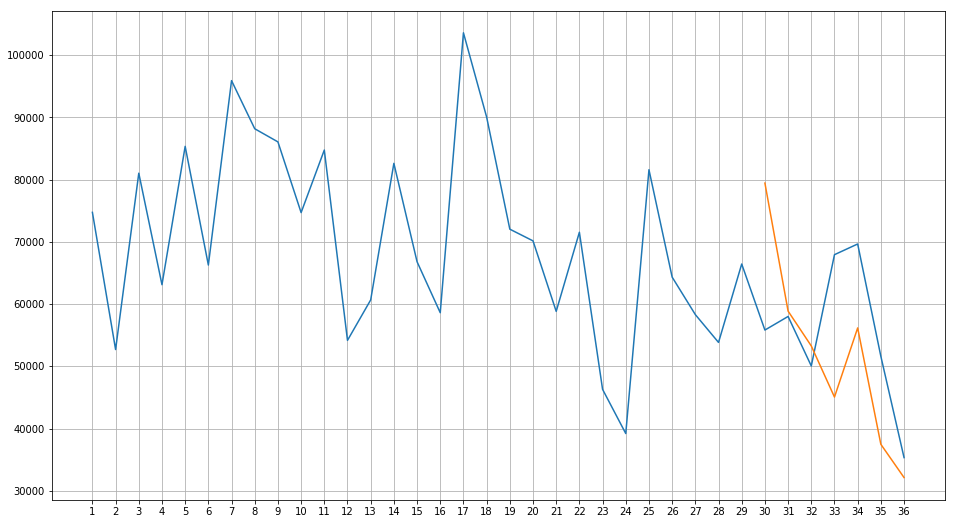

In [132]:
plot('0642/9')

#### Gráficos de comparação entre real e a predição para o total dos meses

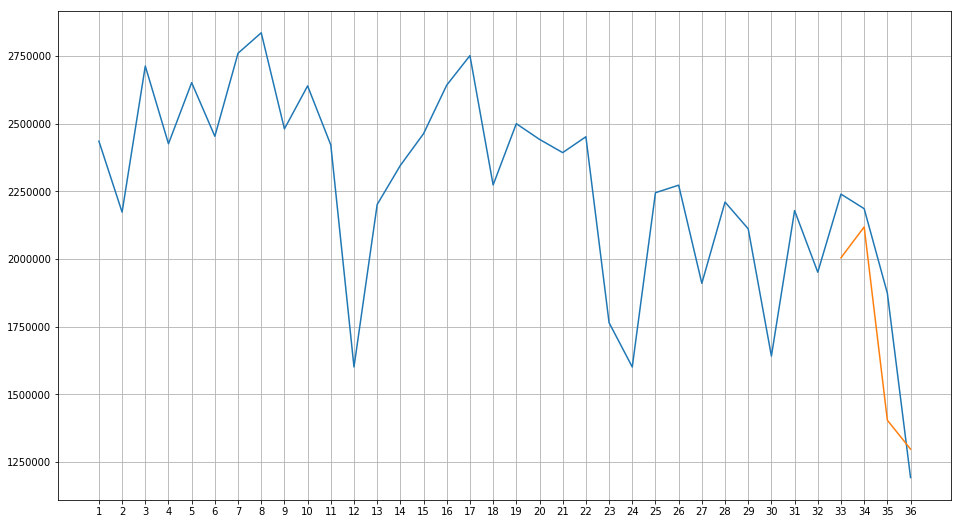

In [133]:
plt.rcParams['figure.figsize']=(16,9)
plt.plot(list(range(1,37)),nf_pred_final.groupby(['Mês_2']).agg({'Quant_2':'sum'}))
pred_plot=nf_pred_final.groupby(['Mês_2']).agg({'pred_2':'sum'})
pred_plot.iloc[0:32,0]=np.nan
plt.plot(pred_plot)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,
            30,31,32,33,34,35,36])
plt.grid(True)